In [152]:
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import cointegration_mult as mult
import Cointegration as coint

importlib.reload(coint)
importlib.reload(mult)

<module 'cointegration_mult' from 'D:\\trades\\pairs_trading_b3\\cointegration_mult.py'>

In [153]:
def loss_own(y, x, volume, period, desv_stop=3.1, price_input_test=0, y_short=True):
    y_test = y.copy()
    x_test = x.copy()
    
    volume = abs(volume)
    if (price_input_test <= 0):
        price_input_test=y_test[0]
    
    price_stop_loss, residue = loss_own_residue(y_test, x_test, period, desv_stop=desv_stop, y_short=y_short)
    return -abs(((price_input_test*volume)-(price_stop_loss*volume)))

def loss_own_residue(y, x, period, desv_stop=3.1, y_short=True):
    y_test = y.copy()
    x_test = x.copy()
    
    last_price = y_test[0].copy()
    penny = 0
    while (True):
        penny=round(penny + 0.01, 2)
        if (y_short):
            y_test[0] = last_price + penny
        else:
            y_test[0] = last_price - penny

        residue = mult.zscore(mult.residue(y_test, x_test, period))
        if(abs(residue[0]) >= desv_stop):
            break
    return y_test[0], residue

def gain_own(y, x, volume, period, price_input_test=0, y_short=True):
    y_test = y.copy()
    x_test = x.copy()
    
    volume = abs(volume)
    if (price_input_test <= 0):
        price_input_test=y_test[0]
    
    price_take_profit, residue = gain_own_residue(y_test, x_test, period, y_short=y_short)
    return abs(((price_input_test*volume)-(price_take_profit*volume)))

def gain_own_residue(y, x, period, y_short=True):
    y_test = y.copy()
    x_test = x.copy()
    
    last_price = y_test[0].copy()
    penny = 0
    while (True):
        penny=round(penny + 0.01, 2)
        if (y_short):
            y_test[0] = last_price - penny
            residue = mult.zscore(mult.residue(y_test, x_test, period))
            if(residue[0] <= 0):
                break
        else:
            y_test[0] = last_price + penny
            residue = mult.zscore(mult.residue(y_test, x_test, period))
            if(residue[0] >= 0):
                break

    return y_test[0], residue

In [154]:
path_data_cart = 'datasets/data_cart.csv'
path_data_yahoo = 'datasets/data_yahoo_adj.csv'
path_data = 'datasets/data.csv'

In [155]:
data = pd.read_csv(path_data_yahoo, index_col=0)
data = data[::-1]
pairs = pd.read_csv('datasets/cointegrated_pairs_mult.csv')

print('{} to {}'.format(data.index[-1], data.index[0]))
print('data: {}'.format(data.shape))
print('pairs: {}'.format(pairs.shape))

2019-05-02 to 2020-07-30
data: (311, 72)
pairs: (1931, 12)


In [156]:
data

,ABEV3,AZUL4,B3SA3,BBAS3,BBDC3,BBDC4,BBSE3,BEEF3,BPAC11,BRAP4,...,SUZB3,TAEE11,TIMP3,TOTS3,UGPA3,USIM5,VALE3,VIVT4,VVAR3,WEGE3
Date,,,,,,,,,,,,,,,,,,,,,
2020-07-30,14.550000,21.020000,64.610001,34.799999,21.500000,23.410000,28.070000,13.97000,86.860001,42.860001,...,42.220001,29.200001,14.800000,26.120001,19.750000,8.210000,61.270000,51.130001,20.200001,68.000000
2020-07-29,15.150000,20.959999,64.629997,35.950001,22.059999,24.260000,28.240000,14.09000,87.830002,44.029999,...,41.490002,28.940001,14.890000,26.090000,19.450001,8.150000,62.950001,50.599998,20.120001,66.980003
2020-07-28,15.090000,21.520000,65.230003,35.029999,21.420000,23.520000,28.070000,14.74000,84.750000,42.919998,...,42.000000,29.070000,14.880000,25.950001,19.500000,7.990000,60.340000,50.970001,20.410000,67.190002
2020-07-27,15.280000,20.709999,66.230003,34.910000,21.580000,23.680000,28.490000,14.08000,87.709999,43.639999,...,41.669998,28.639999,14.570000,26.240000,19.389999,8.090000,61.369999,49.750000,18.910000,69.949997
2020-07-24,14.930000,20.540001,65.349998,33.950001,20.719999,22.639999,28.000000,14.00000,86.400002,41.340000,...,42.299999,28.420000,14.410000,26.360001,19.150000,7.550000,58.599998,49.270000,19.540001,66.583199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-08,17.461390,37.000000,33.200516,48.045422,29.313004,33.003910,24.464645,8.56450,38.829525,29.956003,...,41.279999,24.797062,10.600680,39.247406,21.207283,8.490177,47.735104,41.797237,4.530000,18.321693
2019-05-07,17.198299,35.279999,32.533607,47.000763,26.037483,29.394857,24.598429,8.55466,39.073124,30.347839,...,40.990002,24.496378,11.104092,40.638409,20.885221,8.371434,48.417038,41.888592,4.720000,17.858973
2019-05-06,17.597807,35.000000,32.572273,46.886795,29.048071,32.538929,25.436811,8.72182,39.268005,30.132330,...,41.330002,24.383621,11.065369,41.830807,20.748590,8.688084,48.378067,41.577965,4.560000,18.075565


In [7]:
"""y_symbol = 'ELET3'
x_symbol = 'PCAR3'"""

"""y_symbol = 'CMIG4'
x_symbol = 'ENGI11'"""

y_symbol = 'BRKM5'
x_symbol = 'LAME4'

y = data[y_symbol]
x = data[x_symbol]

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


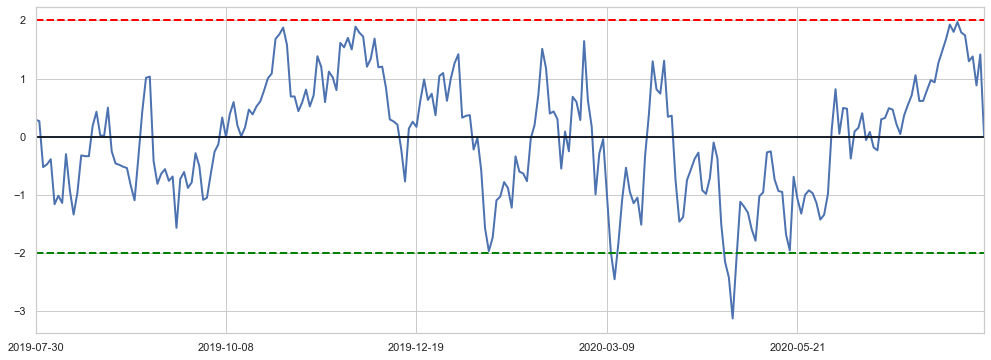

In [8]:
y_rest, resid = gain_own_residue(data['BBAS3'], data['TAEE11'], 250)
mult.plot_residue(resid)

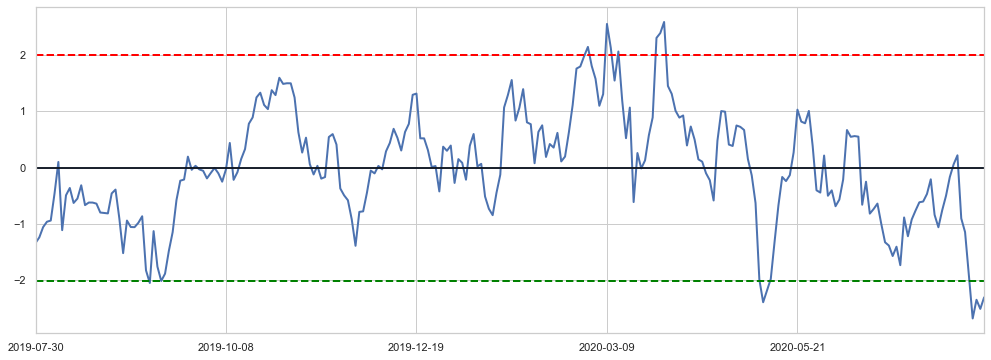

In [9]:
residues = mult.zscore(mult.residue(data['BRML3'], data['GGBR4'], 250))
mult.plot_residue(residues)

In [10]:
residues[0]

-2.3028871130067725

In [11]:
mult.analysis_by_periods(data['ENBR3'], data['FLRY3'])

,Period,Stationary,Std,Dickey-Fuller,ADF,Beta,HalfLife,Corr,Model
0,100,True,0.780898,-4.895155,99,0.453692,2,0.732093,MRLS
1,120,True,0.927248,-5.477457,99,0.515133,2,0.747767,MRLM
2,140,True,1.029398,-5.347743,99,0.545980,2,0.731079,MRLM
3,160,True,0.991091,-5.481158,99,0.547987,2,0.716247,MRLM
4,180,True,0.595353,-5.264883,99,0.560777,3,0.707897,MRLM
5,200,True,0.804162,-5.252046,99,0.547712,3,0.701419,MRLM
6,220,True,1.020758,-5.048967,99,0.532103,3,0.695155,MRLM
7,240,True,1.259560,-4.474901,99,0.506135,4,0.686424,MRLM
8,250,True,1.337158,-4.500447,99,0.494558,5,0.683558,MRLM


In [ ]:
coint.show(data, 'ENBR3', 'FLRY3', 250)

In [207]:
#=PROJ.LIN(DESLOC(AA15;0;0;A$7;1);DESLOC(W15;0;0;A$7;2);1;0)
y, x = mult.get_values(data['ENBR3'], data['FLRY3'], 250)
new = pd.DataFrame()
new['x'] = x
new['y'] = y
#new[::-1].to_excel('datasets/rolling_beta_1.xlsx')

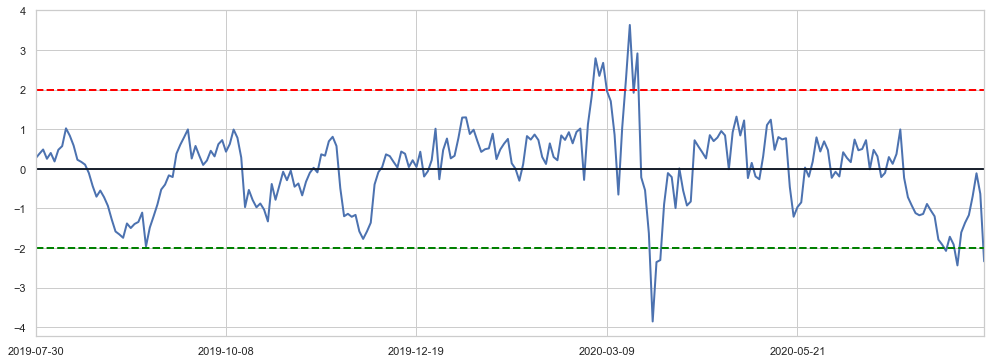

In [157]:
mult.plot_residue(mult.residue(data['ENGI11'], data['RENT3'], 250))

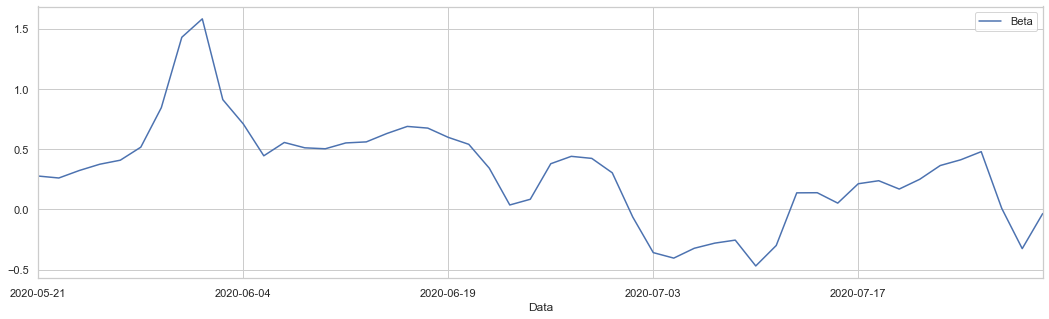

In [225]:
looping = -1
n_recored = 50
period = 10
rows=[]
test=[]
while (looping < (n_recored-1)):
    looping+=1
    dataset = data[looping:]
    y, x = mult.get_values(dataset['ENGI11'], dataset['RENT3'], period)
    #y, x = mult.returns(dataset['ENGI11'], dataset['RENT3'], period)
    #y[0]=0
    #x[0]=0
    
    coef = mult.coefficients(y, x, period)
    beta = coef['angular']
    beta = coint.beta(y, x)
    
    rows.append([dataset.index[0], beta])
    test.append([looping, y.index[0], y.index[-1], beta])

rolling_beta = pd.DataFrame(rows, columns=['Data', 'Beta'])
rolling_beta.set_index("Data", inplace = True)
rolling_beta[::-1].plot(figsize=(18, 5))
#mult.zscore(rolling_beta[::-1]).plot(figsize=(18, 5))

In [189]:
#rolling_beta

In [190]:
mult.coefficients(data['ENGI11'], data['RENT3'], 250)

{'temp': -0.001969899700550911,
 'angular': 0.6768165731215234,
 'intercept': 20.569156818126967}

In [204]:
test[0:20]

[[0, '2020-07-30', '2020-06-19', -0.012781654996139924],
 [1, '2020-07-29', '2020-06-18', -0.1917642575671732],
 [2, '2020-07-28', '2020-06-17', -0.10895087903333689],
 [3, '2020-07-27', '2020-06-16', 0.0586779382035052],
 [4, '2020-07-24', '2020-06-15', 0.14487341436166723],
 [5, '2020-07-23', '2020-06-12', 0.23081712241487695],
 [6, '2020-07-22', '2020-06-10', 0.17533350024635586],
 [7, '2020-07-21', '2020-06-09', 0.157740982254988],
 [8, '2020-07-20', '2020-06-08', 0.20128569408027008],
 [9, '2020-07-17', '2020-06-05', 0.14441667529929436],
 [10, '2020-07-16', '2020-06-04', 0.12281756498466878],
 [11, '2020-07-15', '2020-06-03', 0.11409168580186635],
 [12, '2020-07-14', '2020-06-02', 0.24893367780824294],
 [13, '2020-07-13', '2020-06-01', 0.3320937560187702],
 [14, '2020-07-10', '2020-05-29', 0.3089355257473212],
 [15, '2020-07-09', '2020-05-28', 0.3338766873757122],
 [16, '2020-07-08', '2020-05-27', 0.32750473176523265],
 [17, '2020-07-07', '2020-05-26', 0.453906271356762],
 [18, '

In [213]:
coint.beta(y, x)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


0.6653459007287265

In [214]:
coint.beta(y[::-1], x[::-1])

0.6653459007287269

In [215]:
coint.beta(y[::1], x[::1])

0.6653459007287265